# Loading Libraries
# using numpy, pandas, matplotlib and scikit learn.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, log_loss, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Loading dataset

In [ ]:
def combine_datasets(file1, file2):
    print("=" * 80)
    print("STEP 1: COMBINING DATASETS")
    print("=" * 80)

    df1 = pd.read_csv("/content/data.csv")
    df2 = pd.read_csv("/content/breast-cancer.csv")

    print(f"\nDataset 1 shape: {df1.shape}")
    print(f"Dataset 2 shape: {df2.shape}")

    combined_df = pd.concat([df1, df2], ignore_index=True)
    print(f"Combined dataset shape (before removing duplicates): {combined_df.shape}")

    combined_df = combined_df.drop_duplicates()
    print(f"Combined dataset shape (after removing duplicates): {combined_df.shape}")

    return combined_df

# Data Preprocessing

In [ ]:
def preprocess_data(df):
    print("\n" + "=" * 80)
    print("STEP 2: DATA PREPROCESSING")
    print("=" * 80)

    df = df.drop('id', axis=1, errors='ignore')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.iloc[:, ~df.columns.duplicated()]
    df = df.dropna()

    print(f"\nCleaned dataset shape: {df.shape}")
    print(f"Number of features: {df.shape[1] - 1}")

    X = df.drop('diagnosis', axis=1)
    y = df['diagnosis']
    y = y.map({'M': 1, 'B': 0})

    print(f"\nClass distribution:")
    print(f"  Benign (0): {(y == 0).sum()}")
    print(f"  Malignant (1): {(y == 1).sum()}")
    print(f"  Class balance ratio: {(y == 0).sum() / (y == 1).sum():.2f}:1")

    return X, y

# Feature Scaling

In [ ]:
def scale_features(X):
    print("\n" + "=" * 80)
    print("STEP 3: FEATURE SCALING (Z-SCORE NORMALIZATION)")
    print("=" * 80)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"\nFeature scaling completed")
    print(f"  Mean of scaled features: {X_scaled.mean(axis=0).mean():.6f}")
    print(f"  Std of scaled features: {X_scaled.std(axis=0).mean():.6f}")

    return X_scaled, scaler

# Train-Test Split

In [ ]:
def split_data(X_scaled, y, test_size=0.2, random_state=42):
    print("\n" + "=" * 80)
    print("STEP 4: TRAIN-TEST SPLIT")
    print("=" * 80)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"\nTrain set size: {X_train.shape[0]} samples ({100 * (1 - test_size):.0f}%)")
    print(f"Test set size: {X_test.shape[0]} samples ({100 * test_size:.0f}%)")
    print(f"Number of features: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test

# LOGISTIC REGRESSION FROM SCRATCH

In [ ]:
def initialize_weights_and_bias(dimension):
    w = np.random.randn(dimension, 1) * 0.01
    b = 0.0
    return w, b

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def forward_backward_propagation(w, b, x_train, y_train):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    y_head = sigmoid(z)

    y_train_2d = y_train.values.reshape(-1, 1) if hasattr(y_train, 'values') else y_train.reshape(-1, 1)

    cost = (-1/m) * np.sum(y_train_2d * np.log(y_head + 1e-8) + (1 - y_train_2d) * np.log(1 - y_head + 1e-8))

    derivative_weight = (1/m) * np.dot(x_train.T, (y_head - y_train_2d))
    derivative_bias = (1/m) * np.sum(y_head - y_train_2d)

    gradients = {"derivative_weight": derivative_weight, "derivative_bias": derivative_bias}
    return cost, gradients

def update_parameters(w, b, x_train, y_train, learning_rate, num_iterations):
    costs = []

    for i in range(num_iterations):
        cost, gradients = forward_backward_propagation(w, b, x_train, y_train)

        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]

        if i % 100 == 0:
            costs.append(cost)
            if i % 500 == 0:
                print(f"  Iteration {i}: Cost = {cost:.6f}")

    parameters = {"weight": w, "bias": b}
    return parameters, costs

def predict_logistic(w, b, x_test):
    m = x_test.shape[0]
    y_prediction = np.zeros((m, 1))
    z = sigmoid(np.dot(x_test, w) + b)

    for i in range(m):
        y_prediction[i, 0] = 1 if z[i, 0] > 0.5 else 0

    return y_prediction

def logistic_regression_from_scratch(X_train, X_test, y_train, y_test, learning_rate=0.01, num_iterations=2000):
    print("\n" + "=" * 80)
    print("LOGISTIC REGRESSION FROM SCRATCH (MANUAL IMPLEMENTATION)")
    print("=" * 80)

    dimension = X_train.shape[1]
    w, b = initialize_weights_and_bias(dimension)

    print(f"\nInitializing weights (dimension: {dimension})")
    print(f"Learning rate: {learning_rate}")
    print(f"Number of iterations: {num_iterations}\n")

    parameters, costs = update_parameters(w, b, X_train, y_train, learning_rate, num_iterations)

    y_pred = predict_logistic(parameters["weight"], parameters["bias"], X_test)
    y_pred = y_pred.flatten()

    return {
        'predictions': y_pred,
        'parameters': parameters,
        'costs': costs
    }


# TRAIN SKLEARN MODELS

In [ ]:
def train_sklearn_models(X_train, X_test, y_train, y_test):
    print("\n" + "=" * 80)
    print("STEP 5: TRAINING SKLEARN MODELS")
    print("=" * 80)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    results = {}

    for model_name, model in models.items():
        print(f"\n{'-' * 80}")
        print(f"Training {model_name}...")
        print(f"{'-' * 80}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        results[model_name] = {
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"Training completed for {model_name}")

    return results

# COMPREHENSIVE EVALUATION METRICS

In [ ]:
def calculate_all_metrics(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    print("\n" + "=" * 80)
    print(f"DETAILED METRICS FOR {model_name.upper()}")
    print("=" * 80)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = recall

    log_loss_val = log_loss(y_true, y_pred_proba) if y_pred_proba is not None else None
    auc_score = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n📊 BASIC METRICS:")
    print(f"  Accuracy:      {accuracy:.4f}  (Overall correctness)")
    print(f"  Precision:     {precision:.4f}  (Of predicted positive, how many are actually positive)")
    print(f"  Recall/TPR:    {recall:.4f}  (Of actual positive, how many were identified)")
    print(f"  Specificity:   {specificity:.4f}  (Of actual negative, how many were correctly identified)")
    print(f"  F1-Score:      {f1:.4f}  (Harmonic mean of precision & recall)")

    if log_loss_val is not None:
        print(f"\n📉 PROBABILISTIC METRICS:")
        print(f"  Log Loss:      {log_loss_val:.4f}  (Lower is better)")
        print(f"  AUC Score:     {auc_score:.4f}  (0.5 = random, 1.0 = perfect)")

    print(f"\n🔢 CONFUSION MATRIX BREAKDOWN:")
    print(f"  True Negatives (TN):   {tn}  (Correctly identified negatives)")
    print(f"  False Positives (FP):  {fp}  (Incorrectly predicted as positive)")
    print(f"  False Negatives (FN):  {fn}  (Incorrectly predicted as negative)")
    print(f"  True Positives (TP):   {tp}  (Correctly identified positives)")

    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'specificity': specificity,
        'f1_score': f1, 'log_loss': log_loss_val, 'auc_score': auc_score,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

# VISUALIZATIONS

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name="Model", ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    ax.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=11)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=11)
    ax.set_title(f'ROC Curve - {model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(alpha=0.3)
    return roc_auc

def plot_precision_recall_curve(y_true, y_pred_proba, model_name="Model", ax=None):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    ax.plot(recall, precision, color='green', lw=2.5, label=f'PR curve (AUC = {pr_auc:.4f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'Precision-Recall Curve - {model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc="best", fontsize=10)
    ax.grid(alpha=0.3)
    return pr_auc

def plot_feature_importance(model, feature_names, model_name="Model", top_n=15):
    if not hasattr(model, 'feature_importances_'):
        print(f"Model {model_name} does not support feature importance!")
        return

    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]

    plt.figure(figsize=(11, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
    plt.barh(range(len(indices)), importance[indices], color=colors)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('Importance Score', fontsize=11, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importance - {model_name}', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_metrics_radar(metrics_dict, model_name="Model"):
    categories = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']
    values = [
        metrics_dict['accuracy'],
        metrics_dict['precision'],
        metrics_dict['recall'],
        metrics_dict['specificity'],
        metrics_dict['f1_score']
    ]
    values += values[:1]

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values, 'o-', linewidth=2, color='#FF6B6B')
    ax.fill(angles, values, alpha=0.25, color='#FF6B6B')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(f'Performance Metrics Radar - {model_name}', fontsize=13, fontweight='bold', pad=20)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(X, y, feature_names):
    data = X.copy()
    data['diagnosis'] = y

    correlation = data.corr()
    target_corr = correlation['diagnosis'].sort_values(ascending=False)
    top_features = target_corr.head(16).index.tolist()

    plt.figure(figsize=(12, 10))
    sns.heatmap(data[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
                cbar_kws={'label': 'Correlation Coefficient'}, center=0, linewidths=0.5)
    plt.title('Feature Correlation Matrix with Target Variable', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_cost_function_descent(costs, model_name="Logistic Regression"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(costs)), costs, linewidth=2.5, color='#2E86AB', marker='o', markersize=4)
    plt.xlabel('Iteration (x100)', fontsize=11, fontweight='bold')
    plt.ylabel('Cost (Binary Cross-Entropy Loss)', fontsize=11, fontweight='bold')
    plt.title(f'Cost Function Descent - {model_name}', fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_true, y_pred_proba, model_name="Model"):
    plt.figure(figsize=(10, 6))

    benign_probs = y_pred_proba[y_true == 0]
    malignant_probs = y_pred_proba[y_true == 1]

    plt.hist(benign_probs, bins=30, alpha=0.6, label='Benign Samples', color='#2ECC71', edgecolor='black')
    plt.hist(malignant_probs, bins=30, alpha=0.6, label='Malignant Samples', color='#E74C3C', edgecolor='black')

    plt.xlabel('Predicted Probability of Malignancy', fontsize=11, fontweight='bold')
    plt.ylabel('Frequency', fontsize=11, fontweight='bold')
    plt.title(f'Distribution of Predicted Probabilities - {model_name}', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_class_distribution_pie(y_train, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    train_counts = [sum(y_train == 0), sum(y_train == 1)]
    test_counts = [sum(y_test == 0), sum(y_test == 1)]

    colors = ['#3498DB', '#E74C3C']

    ax1.pie(train_counts, labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Training Set Class Distribution', fontsize=12, fontweight='bold')

    ax2.pie(test_counts, labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Test Set Class Distribution', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_metrics_comparison_table(all_results):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')

    models = list(all_results.keys())
    metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'AUC']

    data = []
    for model in models:
        row = [
            f"{all_results[model]['accuracy']:.4f}",
            f"{all_results[model]['precision']:.4f}",
            f"{all_results[model]['recall']:.4f}",
            f"{all_results[model]['specificity']:.4f}",
            f"{all_results[model]['f1_score']:.4f}",
            f"{all_results[model]['auc_score']:.4f}" if all_results[model]['auc_score'] else "N/A"
        ]
        data.append(row)

    table = ax.table(cellText=data, rowLabels=models, colLabels=metrics,
                     cellLoc='center', loc='center', colWidths=[0.15] * 6)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)

    for i in range(len(metrics)):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(models) + 1):
        table[(i, -1)].set_facecolor('#ECF0F1')
        table[(i, -1)].set_text_props(weight='bold')

    plt.title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def compare_models_bar_chart(all_results):
    models = list(all_results.keys())
    metrics_list = ['accuracy', 'precision', 'recall', 'specificity', 'f1_score']

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    colors = ['#3498DB', '#E74C3C', '#2ECC71']

    for idx, metric in enumerate(metrics_list):
        values = [all_results[m].get(metric, 0) for m in models]

        ax = axes[idx]
        bars = ax.bar(models, values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)

        ax.set_ylabel(metric.capitalize(), fontsize=11, fontweight='bold')
        ax.set_title(f'{metric.capitalize()} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1.05])
        ax.grid(axis='y', alpha=0.3)

        for bar, v in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, v + 0.03, f'{v:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

    fig.delaxes(axes[-1])
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices_comparison(y_test, predictions_dict):
    fig, axes = plt.subplots(1, len(predictions_dict), figsize=(5*len(predictions_dict), 4))

    if len(predictions_dict) == 1:
        axes = [axes]

    for idx, (model_name, y_pred) in enumerate(predictions_dict.items()):
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False,
                   xticklabels=['Benign', 'Malignant'],
                   yticklabels=['Benign', 'Malignant'])
        axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Actual Label', fontsize=10)
        axes[idx].set_xlabel('Predicted Label', fontsize=10)

    plt.tight_layout()
    plt.show()

def create_error_analysis(y_true, y_pred, y_pred_proba=None):
    print("\n" + "=" * 80)
    print("ERROR ANALYSIS REPORT")
    print("=" * 80)

    correct = (y_true == y_pred).sum()
    incorrect = (y_true != y_pred).sum()
    error_rate = incorrect / len(y_true) * 100

    print(f"\nCorrect Predictions:   {correct} ({100 - error_rate:.2f}%)")
    print(f"Incorrect Predictions: {incorrect} ({error_rate:.2f}%)")

    false_positives = ((y_pred == 1) & (y_true == 0)).sum()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum()

    print(f"\nMisclassification Breakdown:")
    print(f"  False Positives (predicted Malignant, actually Benign): {false_positives}")
    print(f"  False Negatives (predicted Benign, actually Malignant): {false_negatives}")



# MAIN EXECUTION


BREAST CANCER DETECTION USING MACHINE LEARNING
Complete Pipeline with Manual & Sklearn Models + Professional Visualizations
STEP 1: COMBINING DATASETS

Dataset 1 shape: (569, 33)
Dataset 2 shape: (569, 32)
Combined dataset shape (before removing duplicates): (1138, 33)
Combined dataset shape (after removing duplicates): (569, 33)

STEP 2: DATA PREPROCESSING

Cleaned dataset shape: (569, 31)
Number of features: 30

Class distribution:
  Benign (0): 357
  Malignant (1): 212
  Class balance ratio: 1.68:1

STEP 3: FEATURE SCALING (Z-SCORE NORMALIZATION)

Feature scaling completed
  Mean of scaled features: -0.000000
  Std of scaled features: 1.000000

STEP 4: TRAIN-TEST SPLIT

Train set size: 455 samples (80%)
Test set size: 114 samples (20%)
Number of features: 30


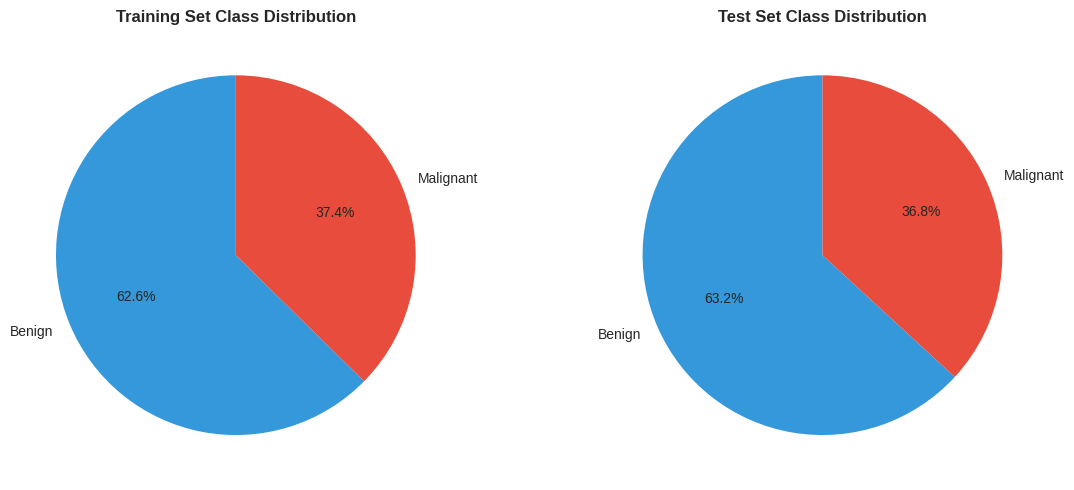


LOGISTIC REGRESSION FROM SCRATCH (MANUAL IMPLEMENTATION)

Initializing weights (dimension: 30)
Learning rate: 0.01
Number of iterations: 2000

  Iteration 0: Cost = 0.675198
  Iteration 500: Cost = 0.130572
  Iteration 1000: Cost = 0.103500
  Iteration 1500: Cost = 0.091878


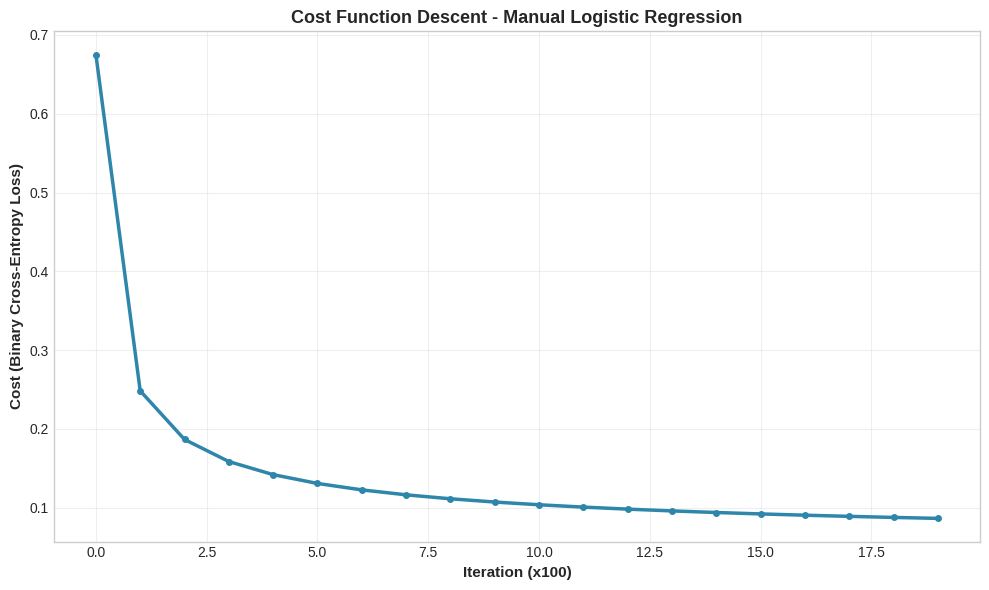


STEP 5: TRAINING SKLEARN MODELS

--------------------------------------------------------------------------------
Training Logistic Regression...
--------------------------------------------------------------------------------
Training completed for Logistic Regression

--------------------------------------------------------------------------------
Training Random Forest...
--------------------------------------------------------------------------------
Training completed for Random Forest

--------------------------------------------------------------------------------
Training XGBoost...
--------------------------------------------------------------------------------
Training completed for XGBoost


COMPREHENSIVE MODEL EVALUATION

DETAILED METRICS FOR MANUAL LOGISTIC REGRESSION

📊 BASIC METRICS:
  Accuracy:      0.9825  (Overall correctness)
  Precision:     1.0000  (Of predicted positive, how many are actually positive)
  Recall/TPR:    0.9524  (Of actual positive, how many were i

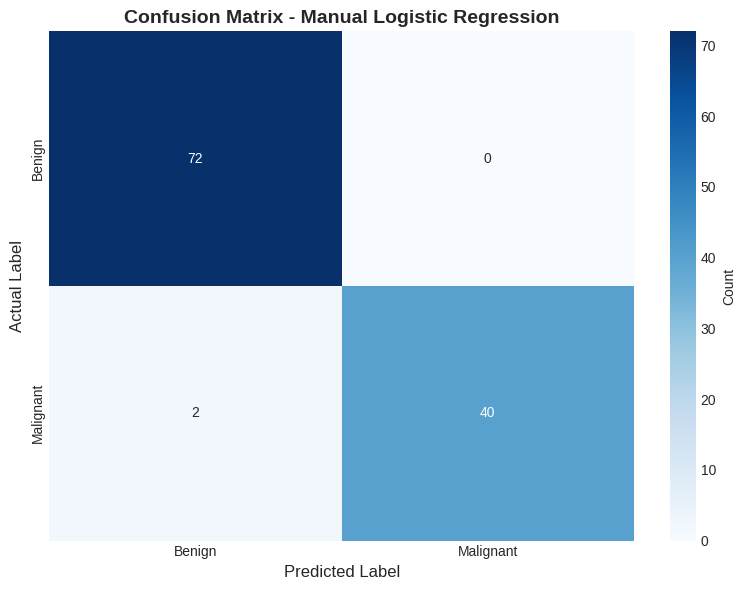

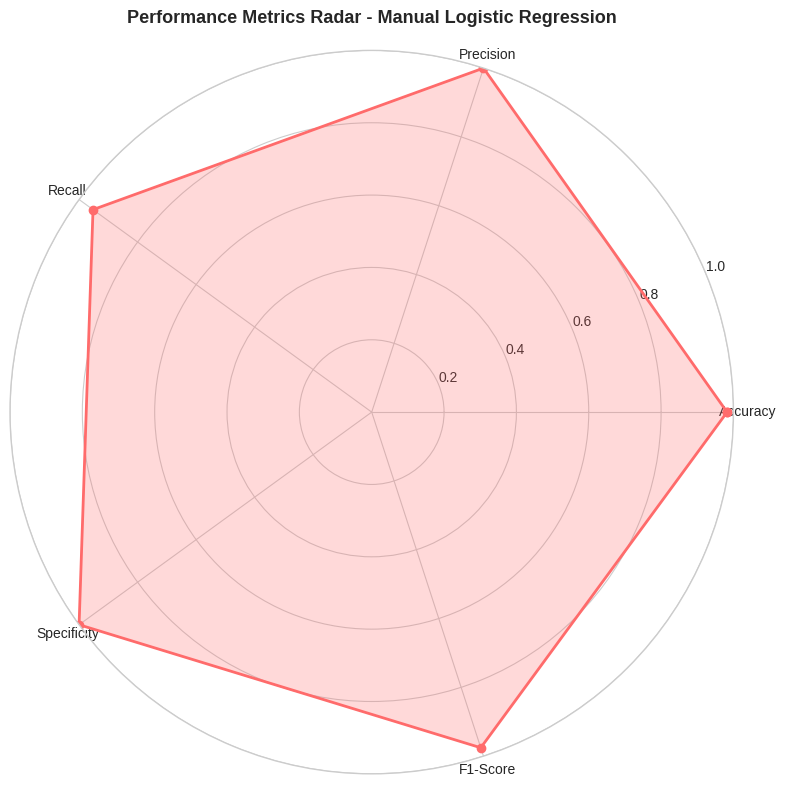


ERROR ANALYSIS REPORT

Correct Predictions:   112 (98.25%)
Incorrect Predictions: 2 (1.75%)

Misclassification Breakdown:
  False Positives (predicted Malignant, actually Benign): 0
  False Negatives (predicted Benign, actually Malignant): 2

DETAILED METRICS FOR LOGISTIC REGRESSION

📊 BASIC METRICS:
  Accuracy:      0.9649  (Overall correctness)
  Precision:     0.9750  (Of predicted positive, how many are actually positive)
  Recall/TPR:    0.9286  (Of actual positive, how many were identified)
  Specificity:   0.9861  (Of actual negative, how many were correctly identified)
  F1-Score:      0.9512  (Harmonic mean of precision & recall)

📉 PROBABILISTIC METRICS:
  Log Loss:      0.0769  (Lower is better)
  AUC Score:     0.9960  (0.5 = random, 1.0 = perfect)

🔢 CONFUSION MATRIX BREAKDOWN:
  True Negatives (TN):   71  (Correctly identified negatives)
  False Positives (FP):  1  (Incorrectly predicted as positive)
  False Negatives (FN):  3  (Incorrectly predicted as negative)
  True 

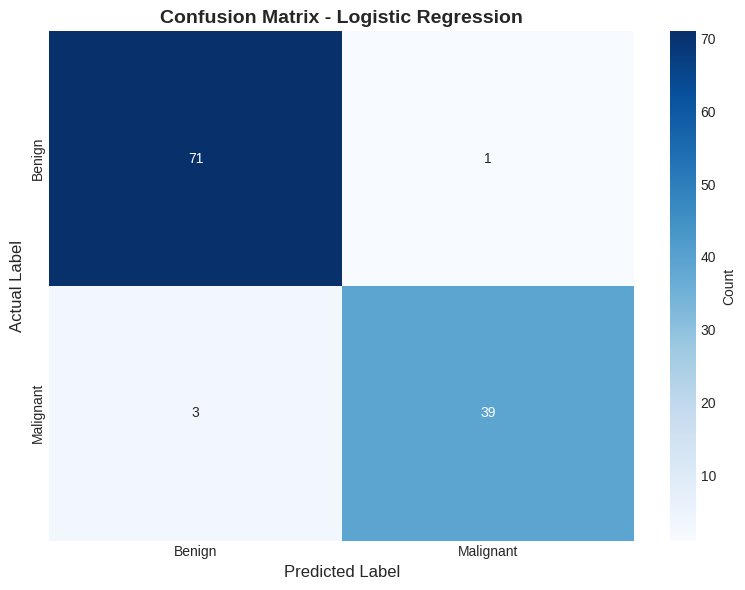

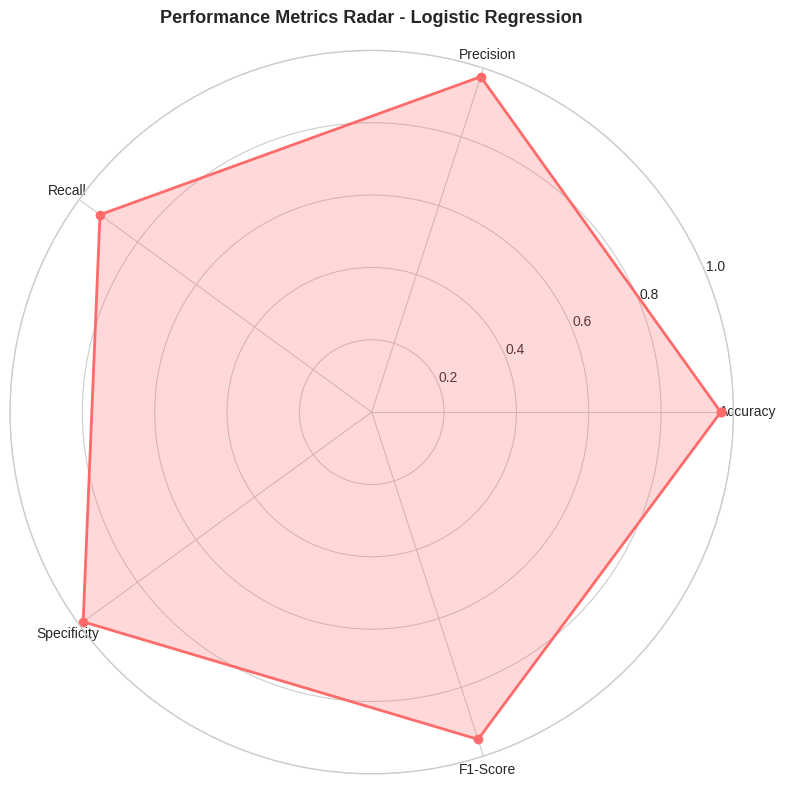

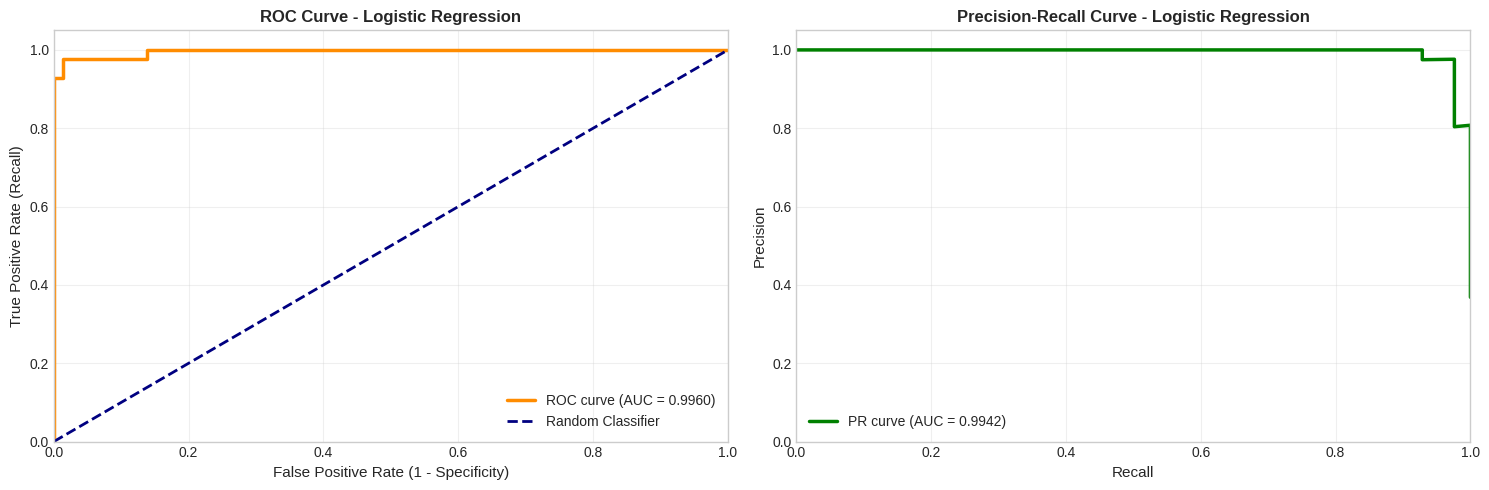

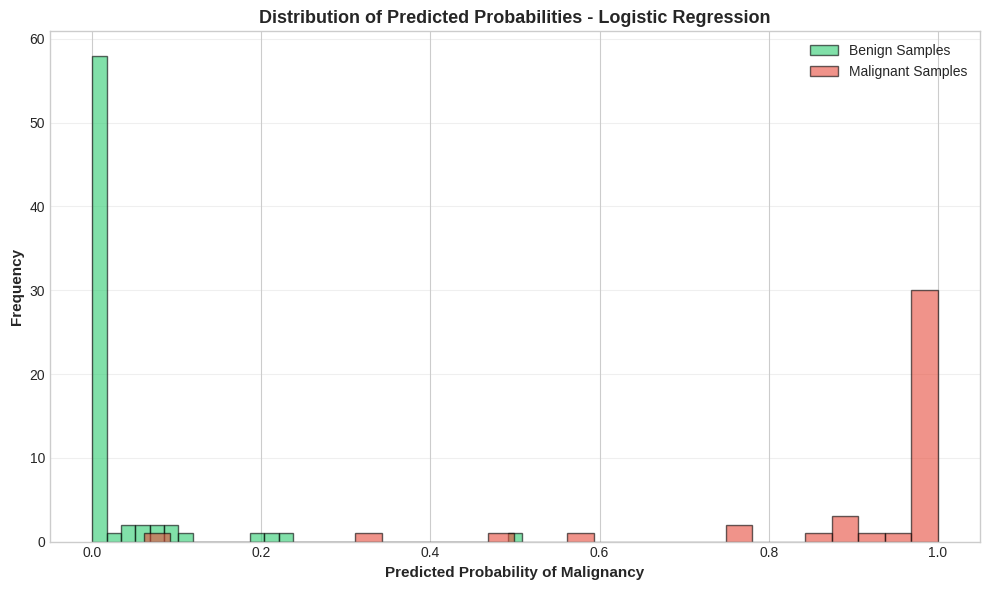


ERROR ANALYSIS REPORT

Correct Predictions:   110 (96.49%)
Incorrect Predictions: 4 (3.51%)

Misclassification Breakdown:
  False Positives (predicted Malignant, actually Benign): 1
  False Negatives (predicted Benign, actually Malignant): 3

DETAILED METRICS FOR RANDOM FOREST

📊 BASIC METRICS:
  Accuracy:      0.9737  (Overall correctness)
  Precision:     1.0000  (Of predicted positive, how many are actually positive)
  Recall/TPR:    0.9286  (Of actual positive, how many were identified)
  Specificity:   1.0000  (Of actual negative, how many were correctly identified)
  F1-Score:      0.9630  (Harmonic mean of precision & recall)

📉 PROBABILISTIC METRICS:
  Log Loss:      0.1170  (Lower is better)
  AUC Score:     0.9929  (0.5 = random, 1.0 = perfect)

🔢 CONFUSION MATRIX BREAKDOWN:
  True Negatives (TN):   72  (Correctly identified negatives)
  False Positives (FP):  0  (Incorrectly predicted as positive)
  False Negatives (FN):  3  (Incorrectly predicted as negative)
  True Positi

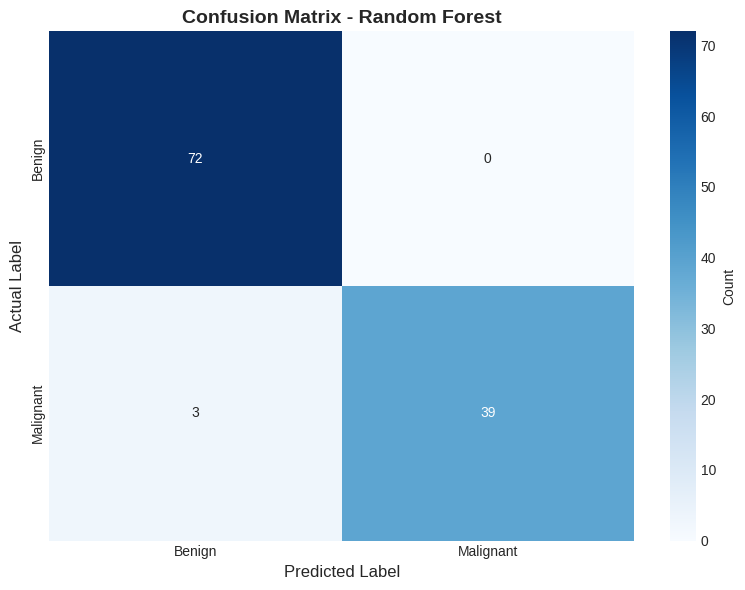

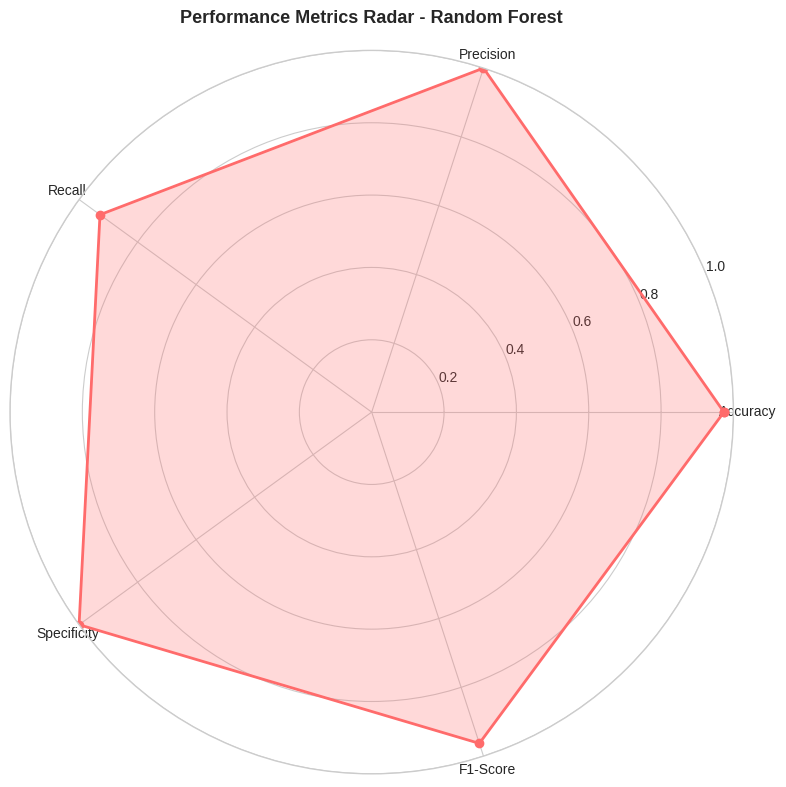

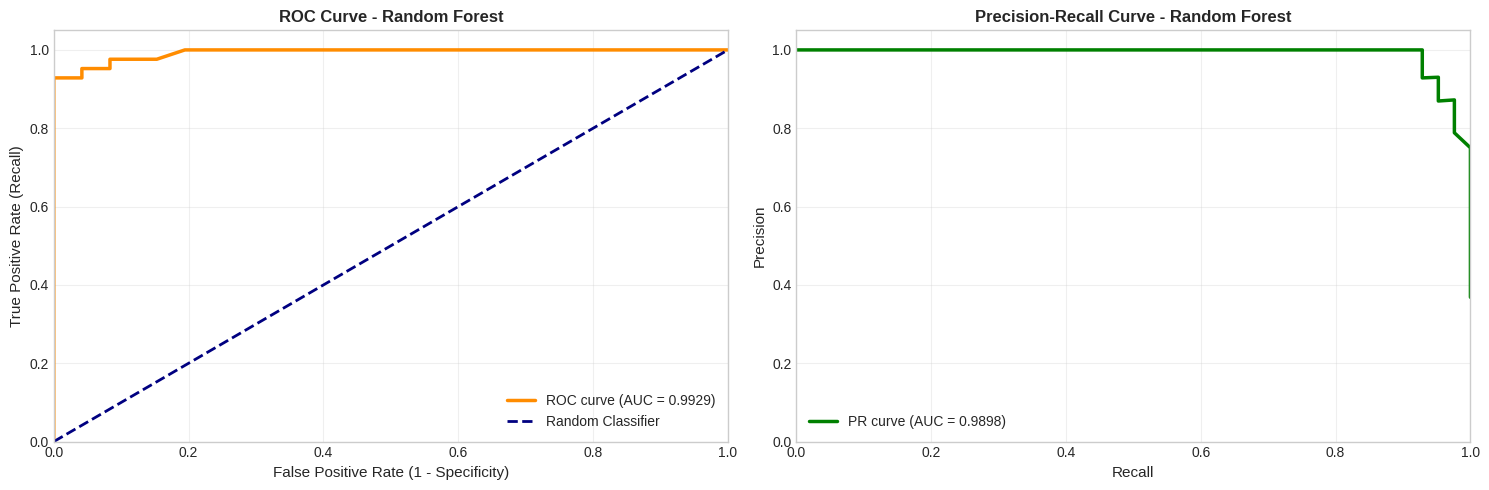

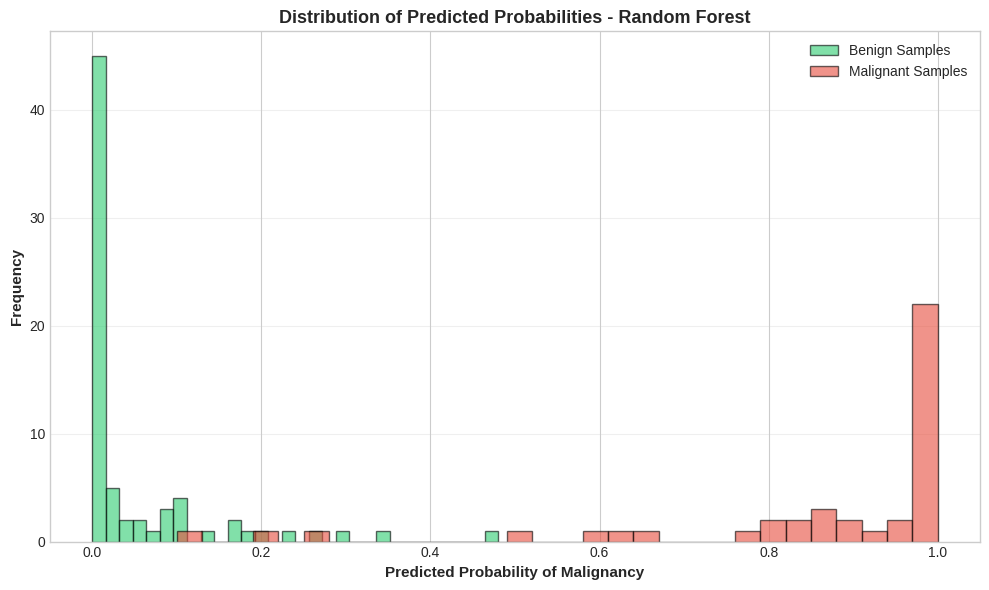

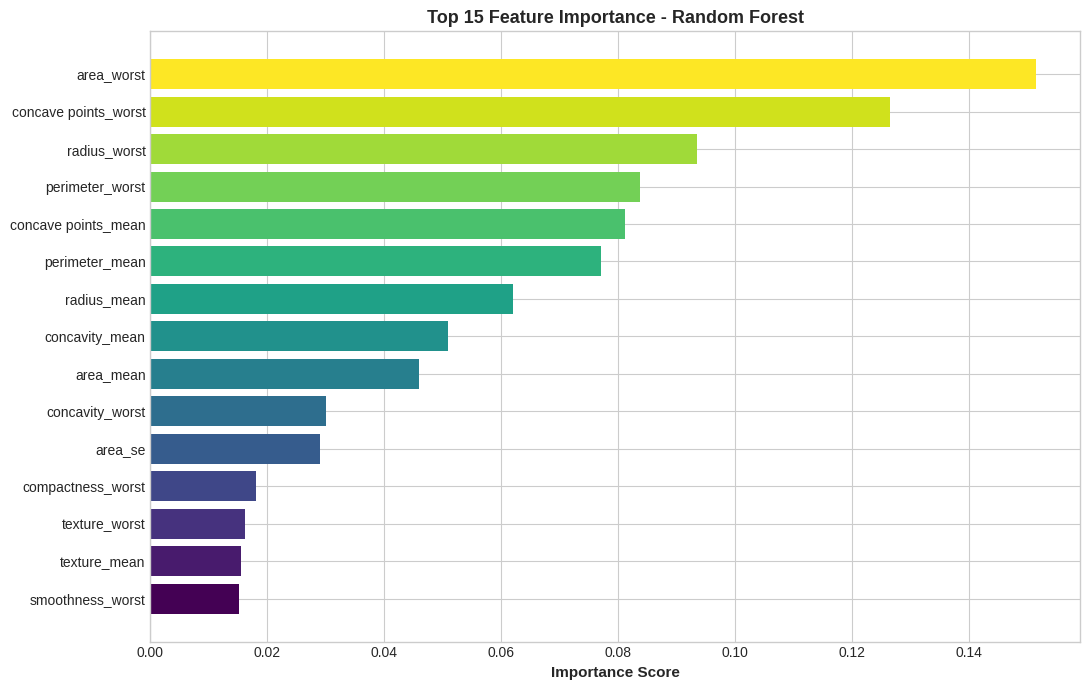


ERROR ANALYSIS REPORT

Correct Predictions:   111 (97.37%)
Incorrect Predictions: 3 (2.63%)

Misclassification Breakdown:
  False Positives (predicted Malignant, actually Benign): 0
  False Negatives (predicted Benign, actually Malignant): 3

DETAILED METRICS FOR XGBOOST

📊 BASIC METRICS:
  Accuracy:      0.9649  (Overall correctness)
  Precision:     1.0000  (Of predicted positive, how many are actually positive)
  Recall/TPR:    0.9048  (Of actual positive, how many were identified)
  Specificity:   1.0000  (Of actual negative, how many were correctly identified)
  F1-Score:      0.9500  (Harmonic mean of precision & recall)

📉 PROBABILISTIC METRICS:
  Log Loss:      0.1279  (Lower is better)
  AUC Score:     0.9947  (0.5 = random, 1.0 = perfect)

🔢 CONFUSION MATRIX BREAKDOWN:
  True Negatives (TN):   72  (Correctly identified negatives)
  False Positives (FP):  0  (Incorrectly predicted as positive)
  False Negatives (FN):  4  (Incorrectly predicted as negative)
  True Positives (T

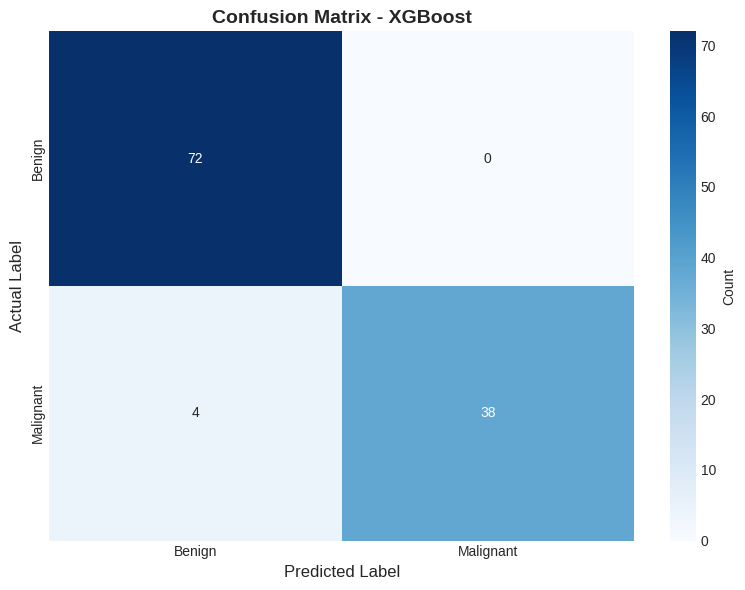

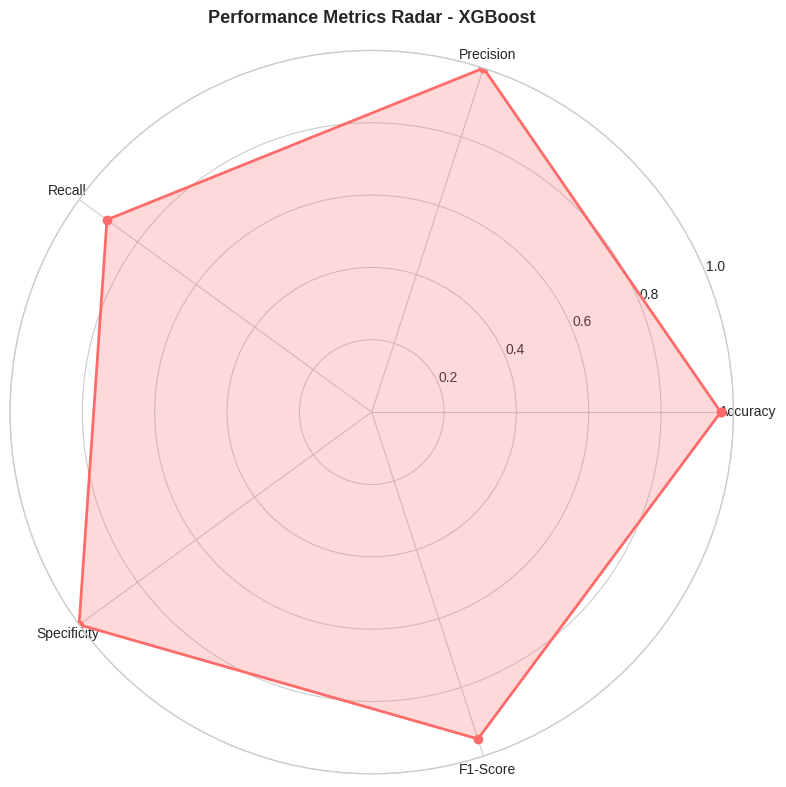

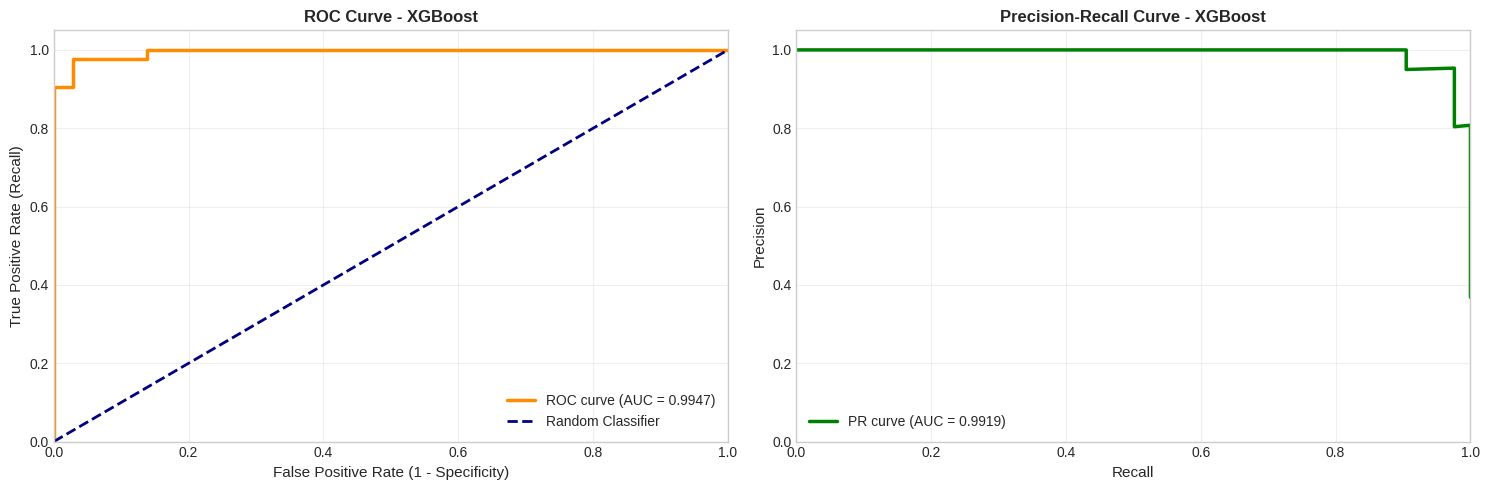

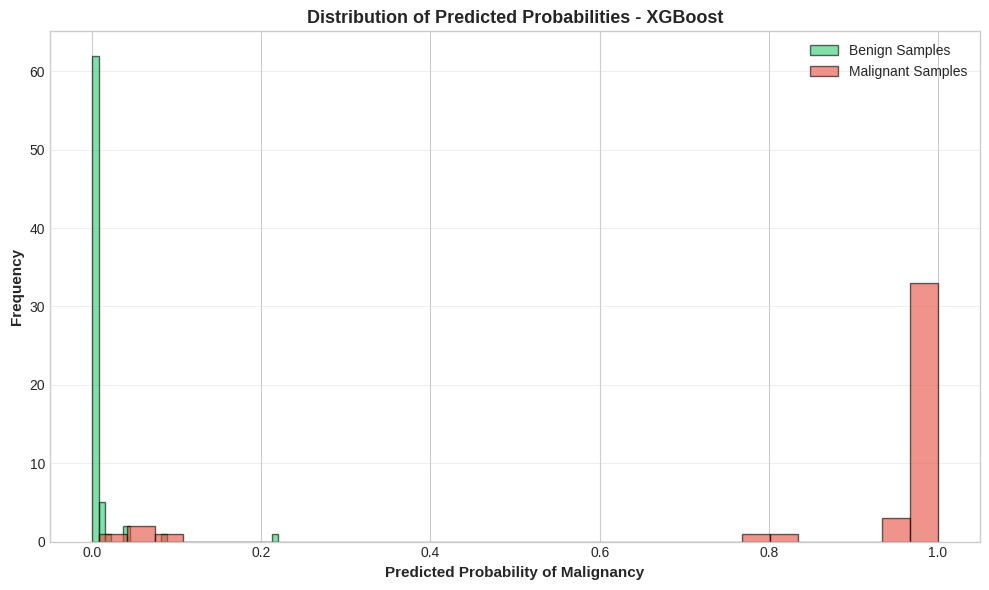

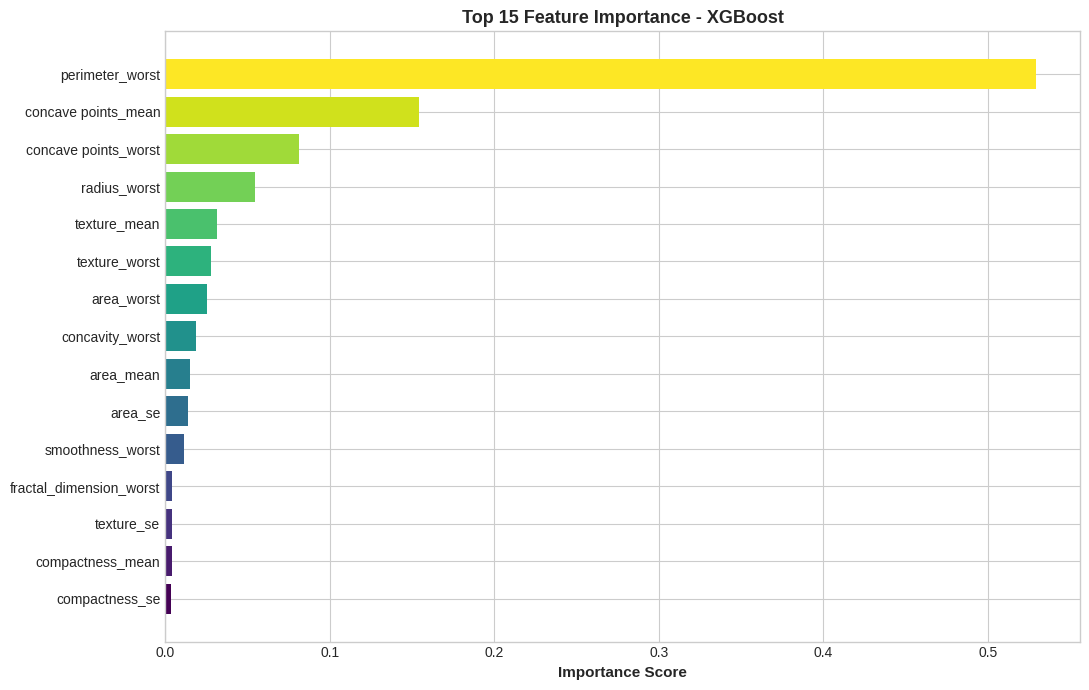


ERROR ANALYSIS REPORT

Correct Predictions:   110 (96.49%)
Incorrect Predictions: 4 (3.51%)

Misclassification Breakdown:
  False Positives (predicted Malignant, actually Benign): 0
  False Negatives (predicted Benign, actually Malignant): 4


GLOBAL CORRELATION ANALYSIS


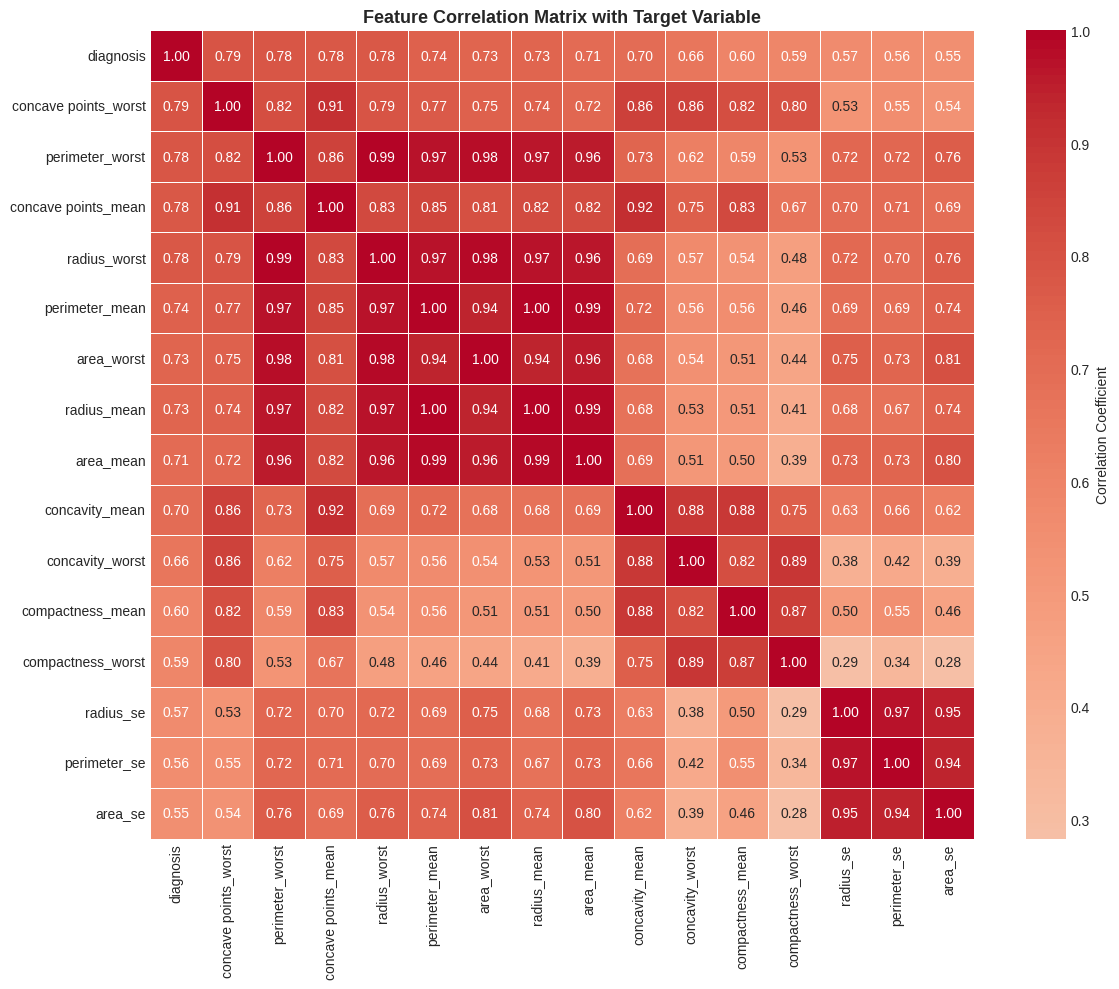



MODEL COMPARISON VISUALIZATIONS


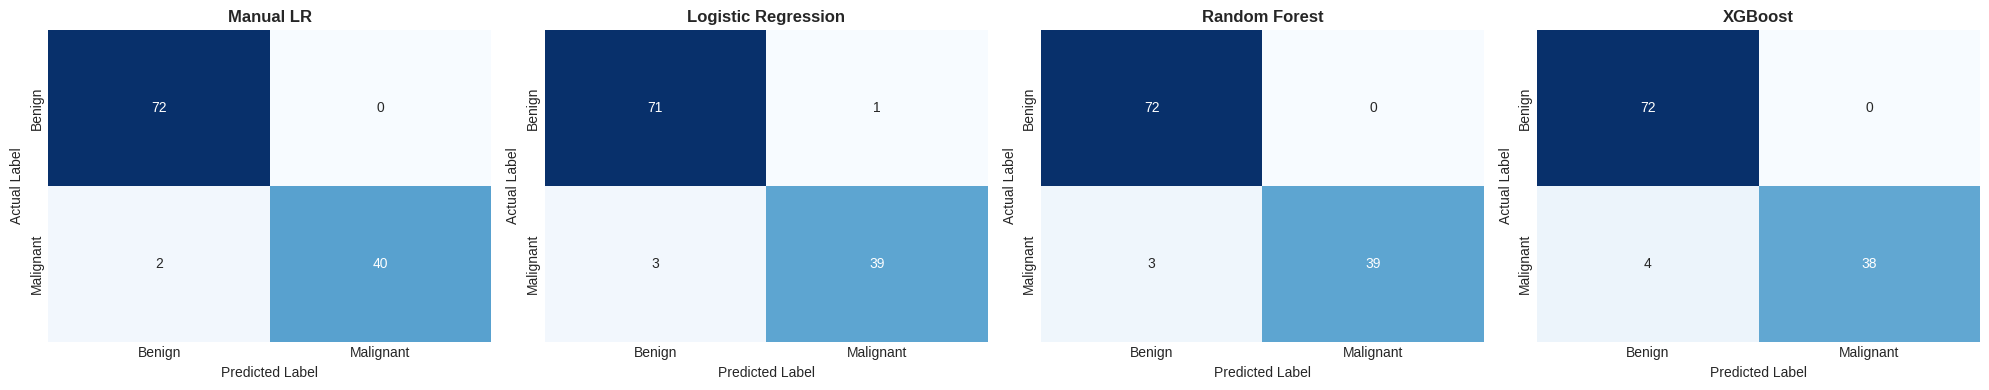

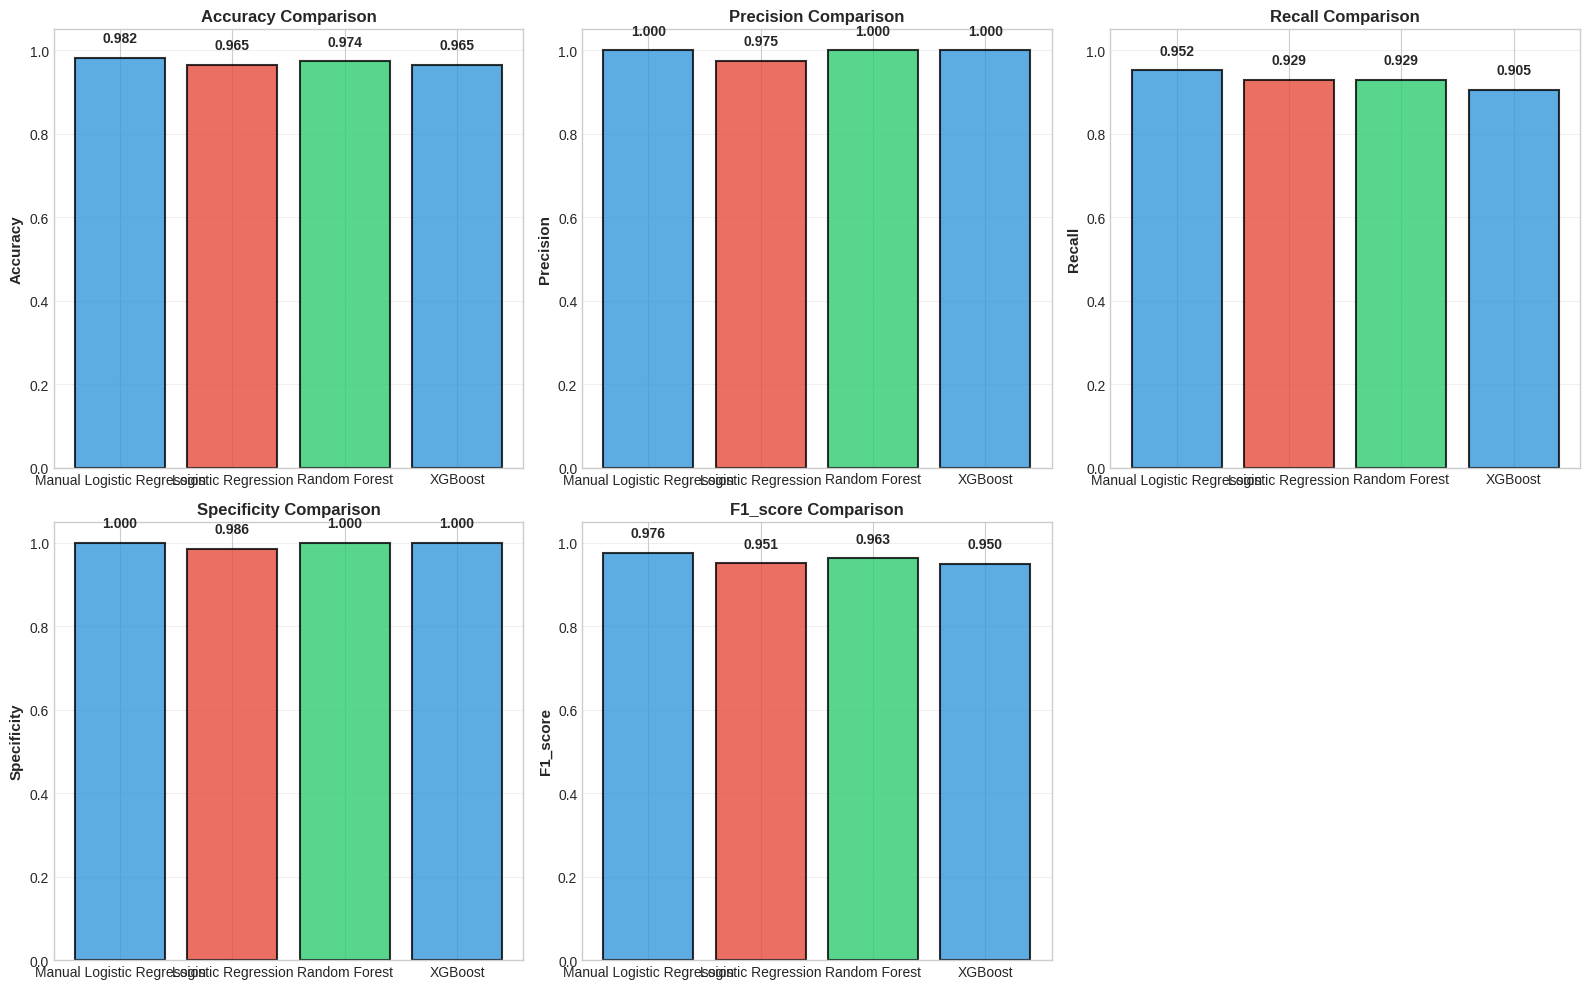

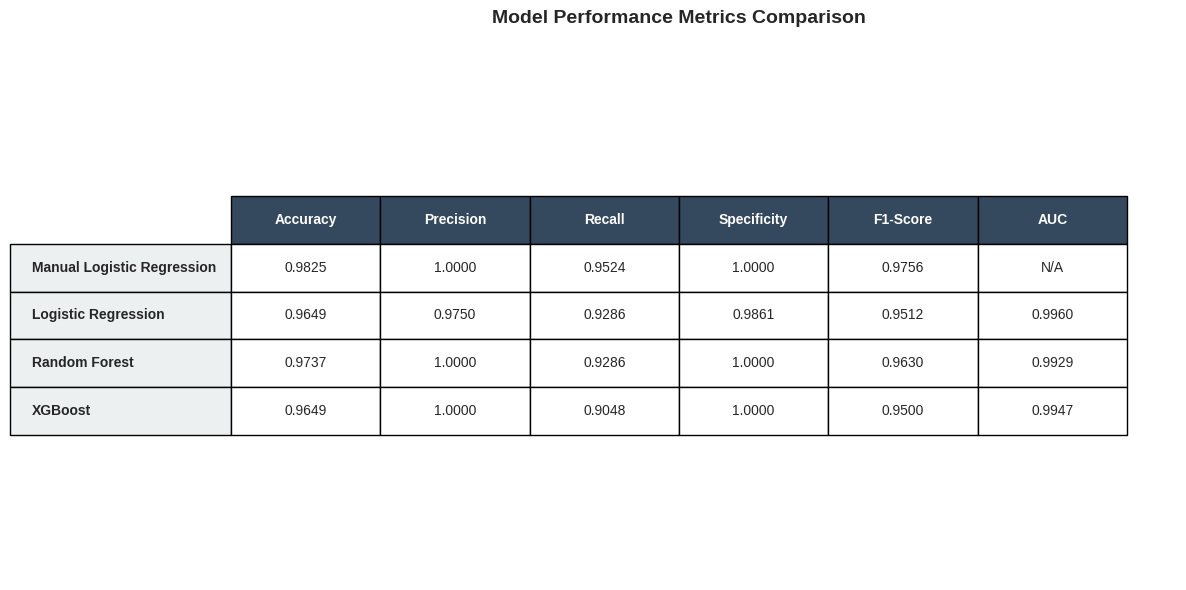



FINAL MODEL PERFORMANCE SUMMARY

Model                          Accuracy     Precision    Recall       F1-Score     AUC         
----------------------------------------------------------------------------------------------------
Manual Logistic Regression     0.9825       1.0000       0.9524       0.9756       N/A         
Logistic Regression            0.9649       0.9750       0.9286       0.9512       0.9960      
Random Forest                  0.9737       1.0000       0.9286       0.9630       0.9929      
XGBoost                        0.9649       1.0000       0.9048       0.9500       0.9947      

KEY FINDINGS AND RECOMMENDATIONS

✓ Best Performing Model: Manual Logistic Regression
  F1-Score: 0.9756
  Accuracy: 0.9825

✓ Model with Highest Sensitivity (Recall): Manual Logistic Regression
  Recall: 0.9524

✓ Model with Highest Specificity: Manual Logistic Regression
  Specificity: 1.0000

✓ Clinical Significance:
  - High Recall is critical (minimize false negatives)
  - Hi

In [ ]:
def main():
    print("\n" + "=" * 80)
    print("BREAST CANCER DETECTION USING MACHINE LEARNING")
    print("Complete Pipeline with Manual & Sklearn Models + Professional Visualizations")
    print("=" * 80)

    # Data preparation
    combined_df = combine_datasets('/content/data.csv', '/content/breast-cancer.csv')
    X, y = preprocess_data(combined_df)
    feature_names = X.columns.tolist()
    X_scaled, scaler = scale_features(X)
    X_train, X_test, y_train, y_test = split_data(X_scaled, y)

    # Visualize class distribution
    plot_class_distribution_pie(y_train, y_test)

    # Manual Logistic Regression
    manual_lr = logistic_regression_from_scratch(X_train, X_test, y_train, y_test,
                                                  learning_rate=0.01, num_iterations=2000)
    manual_pred = manual_lr['predictions']
    manual_costs = manual_lr['costs']

    # Plot cost descent
    plot_cost_function_descent(manual_costs, "Manual Logistic Regression")

    # Sklearn Models
    sklearn_results = train_sklearn_models(X_train, X_test, y_train, y_test)

    # Comprehensive Evaluation
    print("\n\n" + "=" * 80)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("=" * 80)

    all_results = {}
    predictions_dict = {}

    # Manual LR evaluation
    manual_metrics = calculate_all_metrics(y_test, manual_pred, None, "Manual Logistic Regression")
    all_results["Manual Logistic Regression"] = manual_metrics
    predictions_dict["Manual LR"] = manual_pred
    plot_confusion_matrix(y_test, manual_pred, "Manual Logistic Regression")
    plot_metrics_radar(manual_metrics, "Manual Logistic Regression")
    create_error_analysis(y_test, manual_pred)

    # Sklearn models evaluation
    for model_name, model_data in sklearn_results.items():
        metrics = calculate_all_metrics(y_test, model_data['predictions'],
                                        model_data['probabilities'], model_name)
        all_results[model_name] = metrics
        predictions_dict[model_name] = model_data['predictions']

        plot_confusion_matrix(y_test, model_data['predictions'], model_name)
        plot_metrics_radar(metrics, model_name)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        plot_roc_curve(y_test, model_data['probabilities'], model_name, ax=ax1)
        plot_precision_recall_curve(y_test, model_data['probabilities'], model_name, ax=ax2)
        plt.tight_layout()
        plt.show()

        plot_prediction_distribution(y_test, model_data['probabilities'], model_name)

        if 'Random Forest' in model_name or 'XGBoost' in model_name:
            plot_feature_importance(model_data['model'], feature_names, model_name, top_n=15)

        create_error_analysis(y_test, model_data['predictions'], model_data['probabilities'])

    # Global analysis
    print("\n\n" + "=" * 80)
    print("GLOBAL CORRELATION ANALYSIS")
    print("=" * 80)
    plot_correlation_heatmap(pd.DataFrame(X_scaled, columns=feature_names), y, feature_names)

    # Comparison visualizations
    print("\n\n" + "=" * 80)
    print("MODEL COMPARISON VISUALIZATIONS")
    print("=" * 80)

    plot_confusion_matrices_comparison(y_test, predictions_dict)
    compare_models_bar_chart(all_results)
    plot_metrics_comparison_table(all_results)

    # Final summary table
    print("\n\n" + "=" * 80)
    print("FINAL MODEL PERFORMANCE SUMMARY")
    print("=" * 80)
    print(f"\n{'Model':<30} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<12}")
    print("-" * 100)

    for model_name, metrics in all_results.items():
        auc_str = f"{metrics['auc_score']:.4f}" if metrics['auc_score'] else "N/A"
        print(f"{model_name:<30} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1_score']:<12.4f} {auc_str:<12}")

    print("\n" + "=" * 80)
    print("KEY FINDINGS AND RECOMMENDATIONS")
    print("=" * 80)

    best_model = max(all_results.items(), key=lambda x: x[1]['f1_score'])
    worst_model = min(all_results.items(), key=lambda x: x[1]['f1_score'])

    print(f"\n✓ Best Performing Model: {best_model[0]}")
    print(f"  F1-Score: {best_model[1]['f1_score']:.4f}")
    print(f"  Accuracy: {best_model[1]['accuracy']:.4f}")

    print(f"\n✓ Model with Highest Sensitivity (Recall): {max(all_results.items(), key=lambda x: x[1]['recall'])[0]}")
    print(f"  Recall: {max(all_results.items(), key=lambda x: x[1]['recall'])[1]['recall']:.4f}")

    print(f"\n✓ Model with Highest Specificity: {max(all_results.items(), key=lambda x: x[1]['specificity'])[0]}")
    print(f"  Specificity: {max(all_results.items(), key=lambda x: x[1]['specificity'])[1]['specificity']:.4f}")

    print("\n✓ Clinical Significance:")
    print("  - High Recall is critical (minimize false negatives)")
    print("  - High Specificity reduces unnecessary biopsies")
    print("  - Balanced models provide optimal clinical utility")

    print("\n" + "=" * 80)
    print("PROJECT COMPLETED SUCCESSFULLY")
    print("=" * 80 + "\n")

if __name__ == "__main__":
    main()

# BREAST CANCER DETECTION - MODEL SAVING AND LOADING GUIDE

In [ ]:

import joblib
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Create dummy data for demonstration
print("\nCreating dummy data for demonstration...")
X_train = np.random.randn(100, 5)
y_train = np.random.randint(0, 2, 100)
X_test = np.random.randn(20, 5)
y_test = np.random.randint(0, 2, 20)

# Train a simple model
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print("✓ Model trained successfully!")

# Create models directory if not exists
os.makedirs("models", exist_ok=True)

# SAVE THE MODEL
print("\nSaving model to disk...")
joblib.dump(lr_model, "models/logistic_regression.pkl")
print("✓ Saved: models/logistic_regression.pkl")

# LOAD THE MODEL
print("\nLoading model from disk...")
loaded_model = joblib.load("models/logistic_regression.pkl")
print("✓ Loaded: models/logistic_regression.pkl")

# USE LOADED MODEL
predictions = loaded_model.predict(X_test)
print("✓ Made predictions:", predictions[:5])

# ============================================================================ #
# SECTION 4: SAVING MULTIPLE MODELS
# ============================================================================ #

# Define and save multiple models
models_to_save = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

for model_name, model in models_to_save.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    filename = f"models/{model_name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"✓ Saved: {filename}")

# ============================================================================ #
# SECTION 5: SAVING SCALER AND FEATURE NAMES
# ============================================================================ #

scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, "models/scaler.pkl")
print("✓ Saved: models/scaler.pkl")

# Save dummy feature names (if real dataset, use df.columns)
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
joblib.dump(feature_names, "models/feature_names.pkl")
print("✓ Saved: models/feature_names.pkl")



Creating dummy data for demonstration...

Training Logistic Regression model...
✓ Model trained successfully!

Saving model to disk...
✓ Saved: models/logistic_regression.pkl

Loading model from disk...
✓ Loaded: models/logistic_regression.pkl
✓ Made predictions: [1 1 0 0 0]
Training Logistic Regression...
✓ Saved: models/logistic_regression.pkl
Training Random Forest...
✓ Saved: models/random_forest.pkl
Training Gradient Boosting...
✓ Saved: models/gradient_boosting.pkl
✓ Saved: models/scaler.pkl
✓ Saved: models/feature_names.pkl
